In [2]:
# Import our dependencies
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
%matplotlib inline 

In [3]:
# Import our input dataset
df = pd.read_csv('charity_data.csv')
df.head(n=3)

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0


In [3]:
df.shape, df.columns.tolist()

((34299, 12),
 ['EIN',
  'NAME',
  'APPLICATION_TYPE',
  'AFFILIATION',
  'CLASSIFICATION',
  'USE_CASE',
  'ORGANIZATION',
  'STATUS',
  'INCOME_AMT',
  'SPECIAL_CONSIDERATIONS',
  'ASK_AMT',
  'IS_SUCCESSFUL'])

In [4]:
df['SPECIAL_CONSIDERATIONS'].value_counts()

N    34272
Y       27
Name: SPECIAL_CONSIDERATIONS, dtype: int64

In [5]:
df['STATUS'].value_counts()

1    34294
0        5
Name: STATUS, dtype: int64

### Data Model
- IS_SUCCESSFUL will be target for my model
- EIN, NAME should be removed from the input data and the rest variables except IS_SUCCESSFUL will be features for my model
- SPECIAL_CONSIDERATIONS, and STATUS should also be dropped as each of them have a majority of one value, which will not add values for learning

#### Preprocessing

In [4]:
# Remove useless variables
df.drop(['EIN', 'NAME', 'SPECIAL_CONSIDERATIONS', 'STATUS'], axis=1, inplace=True)
df.head(n=3)

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,INCOME_AMT,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,0,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1-9999,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,0,5000,0


In [5]:
# Generate our categorical variable list
cat = df.dtypes[df.dtypes == "object"].index.tolist()

In [6]:
# Check the number of unique values in each column
df[cat].nunique()

APPLICATION_TYPE    17
AFFILIATION          6
CLASSIFICATION      71
USE_CASE             5
ORGANIZATION         4
INCOME_AMT           9
dtype: int64

In [8]:
# Bucketing rare categorical variables
app_type_counts = df['APPLICATION_TYPE'].value_counts()
app_type_counts

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T15        2
T29        2
T17        1
Name: APPLICATION_TYPE, dtype: int64

<AxesSubplot:ylabel='Density'>

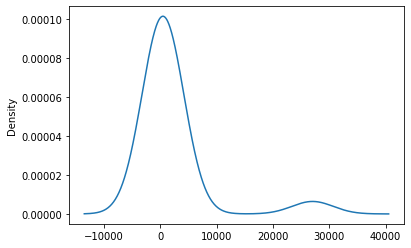

In [9]:
app_type_counts.plot.density()

#### Arbituarily choose value counts cutoff at 500 to bin values to achieve roughly even distribution

In [10]:
# Determine which values to replace
replace_app_type = list(app_type_counts[app_type_counts < 500].index)

# Replace in DataFrame
for app_type in replace_app_type:
    df['APPLICATION_TYPE'] = df['APPLICATION_TYPE'].replace(app_type,"Other")


# Check to make sure binning was successful
df['APPLICATION_TYPE'].value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
Other      276
Name: APPLICATION_TYPE, dtype: int64

In [11]:
classification_counts = df['CLASSIFICATION'].value_counts()
classification_counts

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
         ...  
C1820        1
C1370        1
C2500        1
C2190        1
C1580        1
Name: CLASSIFICATION, Length: 71, dtype: int64

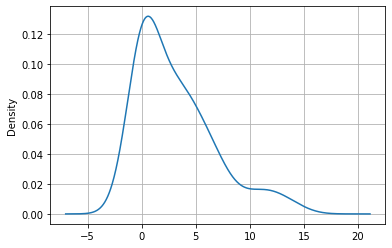

In [12]:
import numpy as np
fig, ax = plt.subplots()
np.log2(classification_counts).plot.density()
ax.grid()

In [13]:
classification_counts[(classification_counts<1000) & (classification_counts> 100)]

C7000    777
C1700    287
C4000    194
C5000    116
C1270    114
C2700    104
Name: CLASSIFICATION, dtype: int64

##### Decide to choose value counts cutoff at 500 to bin values

In [14]:
# Determine which values to replace
replace_classification = list(classification_counts[classification_counts < 500].index)

# Replace in DataFrame
for cls in replace_classification:
    df['CLASSIFICATION'] = df['CLASSIFICATION'].replace(cls,"Other")


# Check to make sure binning was successful
df['CLASSIFICATION'].value_counts()

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
Other     1484
C7000      777
Name: CLASSIFICATION, dtype: int64

<AxesSubplot:ylabel='Density'>

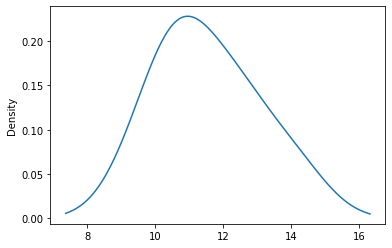

In [15]:
np.log2(df['CLASSIFICATION'].value_counts()).plot.density()

#### Separate features and targets

#### OneHot encoding categorical features

In [16]:
enc = OneHotEncoder(sparse=False)
encode_df = pd.DataFrame()
for fet in cat:
    # Fit the encoder and produce encoded DataFrame
    tmp_df = pd.DataFrame(enc.fit_transform(df[fet].values.reshape(-1,1)))

    # Rename encoded columns
    tmp_df.columns = enc.get_feature_names([fet])
    encode_df = pd.concat([encode_df, tmp_df], axis=1)

encode_df.head()

,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,...,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [19]:
encode_df.shape, df.shape

((34299, 40), (34299, 8))

In [17]:
df_final = df.merge(encode_df, left_index=True,right_index=True).drop(cat, 1)
df_final.head()

,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,...,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M
0,5000,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,108590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5000,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6692,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,142590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# Split our preprocessed data into our features and target arrays
y = df_final["IS_SUCCESSFUL"].values
X = df_final.drop(["IS_SUCCESSFUL"],1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)
X_train.shape

(25724, 41)

In [19]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [20]:
X_train_scaled.shape

(25724, 41)

### Neural Network Classification

In [21]:
# Define the model - deep neural net
number_input_features = len(X_train[0])
hidden_nodes_layer1 = 2* number_input_features

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 82)                3444      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 83        
Total params: 3,527
Trainable params: 3,527
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [23]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train,epochs=50, shuffle=False)

Epoch 1/50
804/804 [==============================] - 1s 687us/step - loss: 0.5728 - accuracy: 0.7203
Epoch 2/50
804/804 [==============================] - 1s 708us/step - loss: 0.5569 - accuracy: 0.72830s - loss: 0.5572 - accuracy: 0.72
Epoch 3/50
804/804 [==============================] - 1s 729us/step - loss: 0.5542 - accuracy: 0.7292
Epoch 4/50
804/804 [==============================] - 1s 751us/step - loss: 0.5525 - accuracy: 0.7314
Epoch 5/50
804/804 [==============================] - 1s 717us/step - loss: 0.5514 - accuracy: 0.7312
Epoch 6/50
804/804 [==============================] - 1s 783us/step - loss: 0.5505 - accuracy: 0.7319
Epoch 7/50
804/804 [==============================] - 1s 729us/step - loss: 0.5498 - accuracy: 0.7322
Epoch 8/50
804/804 [==============================] - 1s 737us/step - loss: 0.5492 - accuracy: 0.7326
Epoch 9/50
804/804 [==============================] - 1s 714us/step - loss: 0.5487 - accuracy: 0.73260s - loss: 0.5456 - accuracy
Epoch 10/50
804/804 

In [24]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5546 - accuracy: 0.7242
Loss: 0.5546209812164307, Accuracy: 0.7241982221603394


<AxesSubplot:>

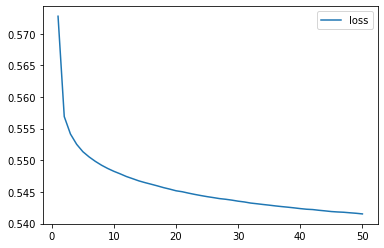

In [25]:
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))
history_df.plot(y="loss")

<AxesSubplot:>

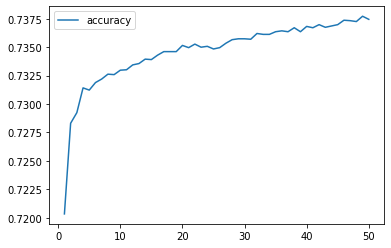

In [26]:
history_df.plot(y="accuracy")

In [27]:
# Increase epocs to see if performance improves
fit_model = nn.fit(X_train_scaled, y_train,epochs=50, shuffle=False)
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
804/804 [==============================] - 0s 604us/step - loss: 0.5415 - accuracy: 0.7378
Epoch 2/50
804/804 [==============================] - 0s 597us/step - loss: 0.5414 - accuracy: 0.7378
Epoch 3/50
804/804 [==============================] - 0s 601us/step - loss: 0.5413 - accuracy: 0.7377
Epoch 4/50
804/804 [==============================] - 0s 592us/step - loss: 0.5413 - accuracy: 0.7378
Epoch 5/50
804/804 [==============================] - 0s 600us/step - loss: 0.5412 - accuracy: 0.7381
Epoch 6/50
804/804 [==============================] - 0s 594us/step - loss: 0.5412 - accuracy: 0.7381
Epoch 7/50
804/804 [==============================] - 0s 593us/step - loss: 0.5411 - accuracy: 0.7381
Epoch 8/50
804/804 [==============================] - 0s 595us/step - loss: 0.5411 - accuracy: 0.7384
Epoch 9/50
804/804 [==============================] - 0s 593us/step - loss: 0.5410 - accuracy: 0.7381
Epoch 10/50
804/804 [==============================] - 0s 600us/step - loss: 0.541

### Deep neural network classification

In [42]:
# Define the model - deep neural net
number_input_features = len(X_train[0])
hidden_nodes_layer1 =  8
hidden_nodes_layer2 = 5

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))


# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 8)                 336       
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 45        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 6         
Total params: 387
Trainable params: 387
Non-trainable params: 0
_________________________________________________________________


In [43]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [44]:
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=50, shuffle=False)

Epoch 1/50
804/804 [==============================] - 0s 459us/step - loss: 0.6066 - accuracy: 0.6978
Epoch 2/50
804/804 [==============================] - 0s 457us/step - loss: 0.5645 - accuracy: 0.7228
Epoch 3/50
804/804 [==============================] - 0s 461us/step - loss: 0.5588 - accuracy: 0.7243
Epoch 4/50
804/804 [==============================] - 0s 459us/step - loss: 0.5562 - accuracy: 0.7253
Epoch 5/50
804/804 [==============================] - 0s 458us/step - loss: 0.5545 - accuracy: 0.7261
Epoch 6/50
804/804 [==============================] - 0s 459us/step - loss: 0.5533 - accuracy: 0.7257
Epoch 7/50
804/804 [==============================] - 0s 458us/step - loss: 0.5524 - accuracy: 0.7268
Epoch 8/50
804/804 [==============================] - 0s 451us/step - loss: 0.5518 - accuracy: 0.7273
Epoch 9/50
804/804 [==============================] - 0s 452us/step - loss: 0.5512 - accuracy: 0.7279
Epoch 10/50
804/804 [==============================] - 0s 456us/step - loss: 0.550

In [45]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5528 - accuracy: 0.7244
Loss: 0.5527504086494446, Accuracy: 0.7244315147399902


<AxesSubplot:>

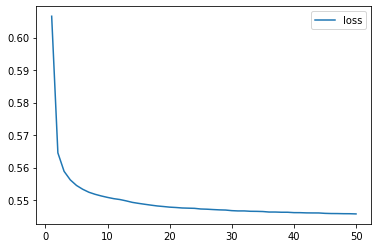

In [46]:
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))
history_df.plot(y="loss")


<AxesSubplot:>

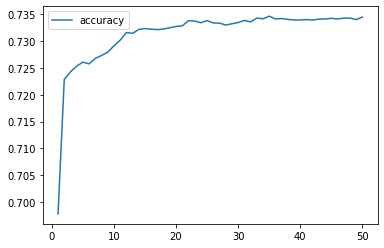

In [47]:
history_df.plot(y="accuracy")

### Explore with adding more nodes in the hidden layers

In [48]:
# Define the model - deep neural net
number_input_features = len(X_train[0])
hidden_nodes_layer1 =  40
hidden_nodes_layer2 = 8

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# 3rd hidden layer
# nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=50, shuffle=False)

# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
804/804 [==============================] - 0s 572us/step - loss: 0.5899 - accuracy: 0.7021
Epoch 2/50
804/804 [==============================] - 0s 558us/step - loss: 0.5558 - accuracy: 0.7266
Epoch 3/50
804/804 [==============================] - 0s 571us/step - loss: 0.5518 - accuracy: 0.7287
Epoch 4/50
804/804 [==============================] - 0s 564us/step - loss: 0.5499 - accuracy: 0.7303
Epoch 5/50
804/804 [==============================] - 0s 564us/step - loss: 0.5488 - accuracy: 0.7318
Epoch 6/50
804/804 [==============================] - 0s 575us/step - loss: 0.5480 - accuracy: 0.7320
Epoch 7/50
804/804 [==============================] - 0s 574us/step - loss: 0.5473 - accuracy: 0.7328
Epoch 8/50
804/804 [==============================] - 0s 577us/step - loss: 0.5467 - accuracy: 0.7330
Epoch 9/50
804/804 [==============================] - 0s 561us/step - loss: 0.5463 - accuracy: 0.7339
Epoch 10/50
804/804 [==============================] - 0s 569us/step - loss: 0.546

### Explore with adding 3rd hidden layer

In [49]:
# Define the model - deep neural net
number_input_features = len(X_train[0])
hidden_nodes_layer1 =  40
hidden_nodes_layer2 = 8
hidden_nodes_layer3 = 4

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# 3rd hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=50, shuffle=False)

# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
804/804 [==============================] - 0s 603us/step - loss: 0.5831 - accuracy: 0.7098
Epoch 2/50
804/804 [==============================] - 0s 604us/step - loss: 0.5548 - accuracy: 0.7301
Epoch 3/50
804/804 [==============================] - 0s 602us/step - loss: 0.5518 - accuracy: 0.7304
Epoch 4/50
804/804 [==============================] - 0s 596us/step - loss: 0.5500 - accuracy: 0.7315
Epoch 5/50
804/804 [==============================] - 0s 600us/step - loss: 0.5491 - accuracy: 0.7319
Epoch 6/50
804/804 [==============================] - 0s 602us/step - loss: 0.5485 - accuracy: 0.7323
Epoch 7/50
804/804 [==============================] - 0s 600us/step - loss: 0.5477 - accuracy: 0.7333
Epoch 8/50
804/804 [==============================] - 0s 602us/step - loss: 0.5470 - accuracy: 0.7334
Epoch 9/50
804/804 [==============================] - 0s 601us/step - loss: 0.5466 - accuracy: 0.7339
Epoch 10/50
804/804 [==============================] - 0s 598us/step - loss: 0.546

### SVM

In [50]:
from sklearn.svm import SVC
# Create the SVM model
svm = SVC(kernel='linear')

# Train the model
svm.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = svm.predict(X_test_scaled)
print(f" SVM model accuracy: {accuracy_score(y_test,y_pred):.3f}")

 SVM model accuracy: 0.720
